In [1]:
import xarray
import numpy as np
import pandas as pd
import matplotlib as mpl
import torch

import matplotlib.pyplot as plt  # plotting library
import plotly.graph_objects as go

# Issue: Maybe downgrade shapely pip install shapely==1.8.5
import cartopy.crs as ccrs  # Projections list
import cartopy.feature as cfeature # for coastlines

torch.set_printoptions(sci_mode = False)
np.set_printoptions(suppress = True)

# Load COST-G data

- **Temporal coverage**: mid-month 2002-04 to mid-month 2023-11 (21.6 years)
- **Normalisation period**: 2002-04 to 2020-03 (what is considered zero) (see "Attributes" > "Summary"). However I found that some pattern remains for this period.
- **dm (delta mass) units**: in mm water equivalent i.e. kg/m^2, grid cell area is provided (in m^2) to convert to mass.
- **Relative notion of mass balance**: Gravity is measured as reletive to a long term average. We can take difference to have monthly changes and to build a temporal model.
- **Release**: RL01
- **Citation**:   Sasgen, I., Groh, A., Horwath, M. (2020):
  COST-G GravIS RL01 Ice-Mass Change Products.
  V. 0003. GFZ Data Services. http://doi.org/10.5880/COST-G.GRAVIS_01_L3_ICE

In [ ]:
# gmb: gravitational mass balance
gmb = xarray.open_dataset(
    "/home/kim/new_massbalance/mass_balance_ConvNP/data/GRACE_GFZ/GRAVIS-3_2002095-2023334_COSTG_0100_AIS_GRID_TUD_0003.nc")

In [18]:
gmb_byrd = gmb.sel(x = slice(350 * 1e3, 550 * 1e3), y = slice(- 1000 * 1e3, -800 * 1e3))

In [19]:
gmb_byrd

<xarray.Dataset>
Dimensions:   (x: 5, y: 5, time: 227)
Coordinates:
  * x         (x) float64 3.5e+05 4e+05 4.5e+05 5e+05 5.5e+05
  * y         (y) float64 -1e+06 -9.5e+05 -9e+05 -8.5e+05 -8e+05
  * time      (time) datetime64[ns] 2002-04-18 2002-05-10 ... 2023-11-16
Data variables:
    time_dec  (time) float64 ...
    lon       (y, x) float64 ...
    lat       (y, x) float64 ...
    dm        (time, y, x) float64 ...
    area      (y, x) float64 ...
    crs       |S1 ...
Attributes: (12/16)
    title:                Gridded AIS Mass Changes
    institution:          TU Dresden, Chair of Geodetic Earth System Research
    authors:              Andreas Groh, Martin Horwath, Thorben Döhne
    project:              GravIS GRACE/GRACE-FO Level-3 Products
    source:               Monthly COST-G RL01 GRACE/GRACE-FO Level-2B product...
    summary:              GRACE/GRACE-FO derived time series of gridded Antar...
    ...                   ...
    product_version:      0003
    doi:                  10.5880/COST-G.GRAVIS_01_L3_ICE
    netCDF_version:       netCDF-4_classic
    conventions:          CF-1.6
    date_created:         2024-04-05
    contact:              thorben.doehne@tu-dresden.de

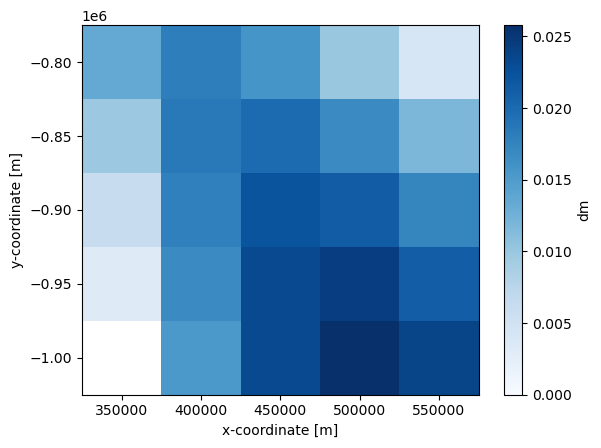

In [ ]:
# factor to convert mm w.e. to meters w.e.
mm_to_meters = 0.001

(gmb_byrd.dm.mean(dim = 'time') * mm_to_meters).plot(cmap = 'Blues', vmin = 0)

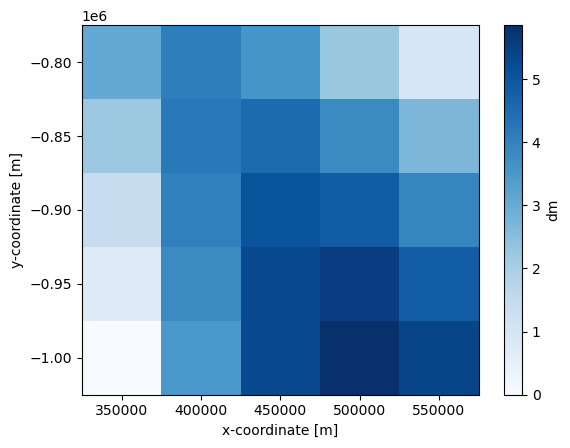

In [21]:
(gmb_byrd.dm.sum(dim = 'time') * mm_to_meters).plot(cmap = 'Blues', vmin = 0)

In [40]:
np.abs(gmb_byrd.dm).max()

<xarray.DataArray 'dm' ()>
array(968.4)

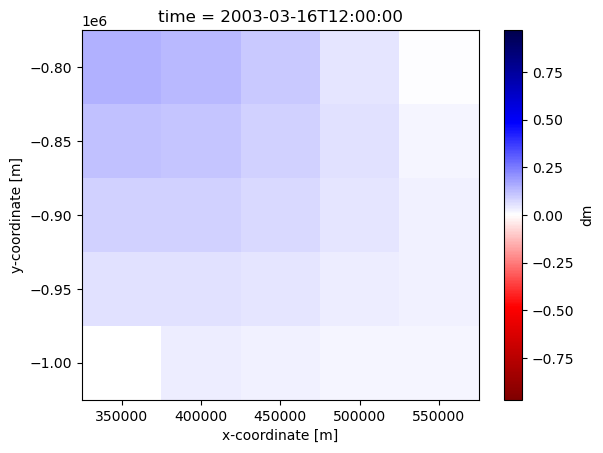

In [60]:
t = 9 # t: months between 2002-01-01 and 2023-10-01

# Choose the maximum absolute value for the color scale
max_abs = np.abs(gmb_byrd.dm).max() * mm_to_meters

(gmb_byrd.dm[t] * mm_to_meters).plot(cmap = 'seismic_r', vmin = - max_abs, vmax = max_abs)

# Yearly mass balance

In [61]:
(gmb_byrd.dm.sum(dim = 'time') * mm_to_meters)

<xarray.DataArray 'dm' (y: 5, x: 5)>
array([[0.    , 3.4858, 5.2954, 5.8537, 5.4144],
       [0.7362, 3.7988, 5.2864, 5.5118, 4.8355],
       [1.4013, 4.0565, 5.0515, 4.8568, 3.9535],
       [2.2391, 4.218 , 4.5275, 3.8119, 2.6825],
       [3.0627, 4.1149, 3.578 , 2.278 , 0.9472]])
Coordinates:
  * x        (x) float64 3.5e+05 4e+05 4.5e+05 5e+05 5.5e+05
  * y        (y) float64 -1e+06 -9.5e+05 -9e+05 -8.5e+05 -8e+05

In [ ]:
n_months = gmb_byrd.dm.shape[0]
n_years = n_months / 12

yearly_mass_balance_water_equivalent = (gmb_byrd.dm.sum(dim = 'time') * mm_to_meters) / n_years
yearly_mass_balance_ice_equivalent = yearly_mass_balance_water_equivalent * 1000 / 917
np.mean(yearly_mass_balance_ice_equivalent) # just under 0.21 meters per year ice equivalent

<xarray.DataArray 'dm' ()>
array(0.2098336)

We observe only minimal glacier thinning compared to the ice flux.

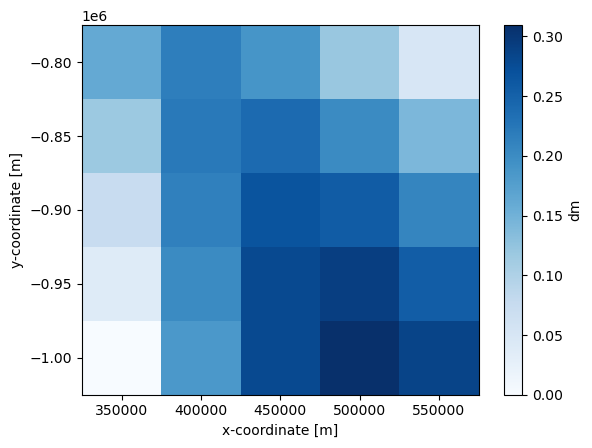

In [74]:
(gmb_byrd.dm.sum(dim = 'time') * mm_to_meters / n_years).plot(cmap = 'Blues', vmin = 0)